This notebook will be for analysis of the data at the county level. In particular, we want to take a closer look at our missing data, since we want to have an idea of how it compares to other counties. 

# What are we interested in?

Our primary question to answer is *do the data suggest that there are forms of racial profiling or bias present in the ways California Police Officers conduct traffic stops*?

Why California? Aside from being a California native that is interested in the dynamics of his own state, one claim I sometimes see or hear is that racism in the more liberal states of the USA is dead, and is more reserved for the "Deep South". This is not a claim on my part, but rather a sentiment that Californians often espouse. California, aside from some counties, is a very blue state, with a large social justice community. Does that then imply that California police are relatively unbiased? Presently, we have no other state to compare to, and that's for several reasons. 

First, any comparison I make is an implicit criticism, since I would have to select a state to compare to, which turns into a judgement on what I apriori believe to be a more racist state. I'm not sure I can make this judgement fairly. Why not compare to all states? Because there are 30+ datasets that would each require exploration and cleaning, which is time consuming. Also, it's not very interesting, because Pierson et al. at https://openpolicing.stanford.edu/findings/ has already done the aggregate analysis for most of the states in the USA, and since I likely could not do a better job, I defer the reader to here. 

Second, California is a huge state, with a large amount of data, and I think that exploring California on its own makes for an interesting project.

Since our concern is bias in the police, we have to think of ways we can look at bias. With the data we have, our primary concern has to do with the search, arrest and contraband "hit" rates for the counties in California. In particular, we want to take a look at the county level data and get an idea of whether counties in California are approximately homogeneous or if there are some systemic differences in the counties. If counties are fairly different, then the search, arrest and hit rates will be different in each county, and we'll need to take that information into account when we take on the task of actually modeling data. 

In [1]:
library(binom)
library(dplyr)
library(ggplot2)
library(geeM)

Warning message:
"package 'dplyr' was built under R version 3.5.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.5.2"Loading required package: Matrix


In [2]:
f <- "caTrafficAgg.csv"
data <- read.csv(f)

## The data

The data in this notebook consists of an aggregated version of the California traffic stop data. The original data is at an individual level, where each row consists of a particular traffic stop and its details. In previous scripts and notebooks, I have aggregated this data so that instead a row consists of information on the year/county/race level. This can be more readily seen by inspecting the head provided blow. Each row has a year, has a county, and has a demographic, as well as the number of traffic stops for that race, the number of searches, tickets, traffic collisions, etc. Right now, we mostly want to get a big picture view of the data by exploring these aggregate data instead of the individual level data, which is so large as to be computationally burdensome. 

While we will do a little bit of modeling here, nothing that may allow us to really infer if police are acting biased or not. Mostly, we will just get some idea of how frequent searches are for each county and (potentially) each demographic. This will give us an idea of whether California's counties could be treated as homogeneous or not. 

## A simple model for searches, arrests, hits

To better understand our data, we can come up with a simple model. Each county has a number of stops, a number of searches, arrests, etc. Since a car can only get searched by the police after it has been stopped by the police, we can think of each search or arrest as the outcome of a bernoullii trial, where the "trial" was the traffic stop itself. Let $X_i$ be a bernoulli random variable denoting the $i$th traffic stop, then

$$X_i = \begin{cases}
    1, \quad \text{Police earches the car} \\
    0, \quad \text{Police does not search}
    \end{cases}$$
    
So now, if we have $1000$ traffic stops, we really have 1000 bernoulli random variables, where the outcome is 1 if a search was conducted, and 0 if a search was not conducted. This lets us cast our data into a probabilistic light: What is the probability of being searched? That is, what $P(X = 1)$? Note that the probability here is actually the expected value:

$$\begin{align}
E[X] & = (1)P(X = 1) + (0)P(X=0)\\
& = P(X=1)
\end{align}$$

which we can estimate with statistics.

We can actually generalize this notion by realizing that a bernoulli random variable is actually a special case of a binomial random variable, which describes the following: "Out of $n$ trials, what is the probability of $k$ successes?" Put to our traffic data, we can ask, "Out of $1000$ traffic stops, what is the probability of $k = 1, 2, ..., 1000$ searches?" The binomial random variable has the following probability distribution:

$$P(X = k) = {n \choose k} p^k (1 - p)^{n-k}$$

Here we have $n$, the number of traffic stops, from the data, and we can estimate the probability of a search $p$ with some statistical estimators. If we replace "search" with "arrest" then we have a model for estimating the probability of an arrest. We can also look at the contraband hit rates by changing $n$ to be the number of *searches* and $k$ to be the number of "hits" for *finding contraband*. The bernoulli case follows by taking $n=1$ and $k = 0, 1$. 

However, we don't neccesarily have the same probability of a search for every traffic stop. It can depend on various things, including county. Police departments in different counties may have different standards, counties may have different kinds of populations, and even different demographics may carry contraband or induldge in criminal behaviour at different rates. To fully understand this, we will need a more expressive model that can account for these things. *We're going to get there.* But for now, we will take this simple binomial model and apply it to the aggregated data at the county level, because first we want to answer the question: *Are the counties different?*

## Estimation

We have the data, how do we estimate the probability of a search/arrest/hit? That is, in the binomial model, how do we estimate $p$ above? For each county, we have a binomial distribution, as above. We also have multiple years. Assuming that the data are identitally distributed for each year, the likelihood function of the binomial model (for a county $j$) is

$$L(p_j|n_i, y_i) = \prod_{i = 1}^m {n_i \choose y_i} p_j^{y_i} (1 - p_j) ^ {n_i - y_i} \quad (1)$$

where $m$ is the number of years the data was recorded. That is, for each year $i = 1, 2, ..., m$, we have a number of traffic stops $n_i$, and searches, arrests, tickets, etc, which can all be denoted by $y_i$. By choosing $p_j$ that maximizes this equation, we get an estimate of $p$ that is most likely to explain the data we have on hand. The $j$ index is just indicating that we are looking at the $j$th county, instead of pooling them all together. The estimate $\hat{p}_j$ can be found by taking the log transformation of the above equation, taking the derivative with respect to $p_j$, setting equal to $0$ and solving. We'll omit some steps, but taking the log gives

$$\sum_i^m log {n_i \choose y_i} + y_i log p_j + (n_i - y_i) log(1 - p_j) \quad (2)$$

and the first order condition is

$$\sum_i^m \frac{y_i}{p_j} - \frac{n_i - y_i}{1 - p_j} = 0 \quad (3)$$.

Solving for $p_j$ then gives the maximum likelihood estimate

$$\hat{p}_j = \frac{\sum_i^m y_i}{\sum_i^m n_i} \quad (4)$$

which is just the sample mean from the data over all years. Note that this model is limited, but it will be useful for our purposes.

In [3]:
head(data)

X,year,county_name,driver_race,stops,num_males,suspect_dui,move_violation,searches,non_arrest_srch,consent,probable,hits,arrests,warnings,chp215,collisions,chp281
1,2009,Alameda County,Asian,13866,9284,729,5160,288,109,0,7,4,254,2068,6586,1163,305
2,2009,Alameda County,Black,20905,12575,1001,6531,1372,656,1,44,34,957,3098,11143,937,176
3,2009,Alameda County,Hispanic,25616,20236,973,7263,1663,1006,2,33,24,909,3036,11743,1371,962
4,2009,Alameda County,Other,13053,9709,410,5000,307,143,0,14,12,229,1475,7093,801,387
5,2009,Alameda County,White,40714,27633,1123,14600,849,379,1,34,24,707,5585,19495,2734,918
6,2009,Alpine County,Asian,341,264,22,168,2,1,0,1,1,4,120,108,6,9


First, we want to get an idea of the county level search, hit, and arrest rates, as well as extra information such as warnings, tickets, etc. Since we are just trying to paint an overall picture, we'll just group everything up by county. We won't worry too much about the year or racial divisions - at least not yet. We're still in exploration mode. Assuming that the counties didnt change too much between years, each county should be (close) to identically distributed, so we can just sum over the years and look at the counties in aggregate.

In [4]:
aggdata <- data %>%
                group_by(county_name) %>%
                    summarise(stops = sum(stops),
                              suspect_dui = sum(suspect_dui),
                              move_violation = sum(move_violation),
                              searches = sum(searches),
                              non_arrest_srch = sum(non_arrest_srch),
                              consent = sum(consent),
                              probable = sum(probable),
                              hits = sum(hits),
                              arrests = sum(arrests),
                              warnings = sum(warnings),
                              chp215 = sum(chp215),
                              collisions = sum(collisions),
                              chp281 = sum(chp281))

head(aggdata)

county_name,stops,suspect_dui,move_violation,searches,non_arrest_srch,consent,probable,hits,arrests,warnings,chp215,collisions,chp281
Alameda County,1718444,67388,579399,63198,28124,93,1996,1305,45826,282021,801185,112556,46755
Alpine County,91785,3719,48563,2545,654,18,195,147,2267,33014,32356,2069,2389
Amador County,87788,1229,38109,1844,1029,2,117,90,1321,16432,30135,2846,5476
Butte County,228030,9224,102837,8377,3259,16,451,349,6740,54817,107794,10041,7026
Calaveras County,95447,1771,37810,2395,996,7,67,48,2019,27488,20674,4214,6503
Colusa County,105650,1903,64207,2283,1397,15,344,267,1447,19737,54978,2246,601


And now let's take a quick summary. Notice the HUGE variance in total population in counties, where the minimum is 1158 and the maximum is over 10 million. Those are Alpine and Los Angeles, respectively, by the way. The NA is our `Missing` county, since we don't have a population estimate on that county yet. 

In [5]:
#the sum of all the stops is the number of individual level data points in the original data
sum(aggdata$stops)

[1] 31721146

In [6]:
summary(aggdata)

           county_name     stops          suspect_dui     move_violation   
 Alameda County  : 1   Min.   :  43166   Min.   :   654   Min.   :  20030  
 Alpine County   : 1   1st Qu.: 129048   1st Qu.:  2814   1st Qu.:  61851  
 Amador County   : 1   Median : 265884   Median :  7961   Median : 102837  
 Butte County    : 1   Mean   : 576748   Mean   : 17830   Mean   : 239740  
 Calaveras County: 1   3rd Qu.: 510100   3rd Qu.: 16501   3rd Qu.: 224124  
 Colusa County   : 1   Max.   :5998360   Max.   :248881   Max.   :2281767  
 (Other)         :49                                                       
    searches      non_arrest_srch    consent         probable     
 Min.   :   649   Min.   :  277   Min.   :  1.0   Min.   :  55.0  
 1st Qu.:  3798   1st Qu.: 1778   1st Qu.: 10.5   1st Qu.: 258.5  
 Median :  9335   Median : 3772   Median : 20.0   Median : 434.0  
 Mean   : 19611   Mean   : 8608   Mean   :133.5   Mean   : 709.5  
 3rd Qu.: 18156   3rd Qu.: 8750   3rd Qu.:110.5   3rd Qu.

Now let's just compute some rates for the count data and the aggregated count data. Since we're assuming that the counties didn't really change over the years, we can just take a simple mean of the search rates to get the MLE estimate of $p$ derived earlier.

In [7]:
aggdata$search_rate <- aggdata$searches / aggdata$stops
aggdata$hit_rate <- aggdata$hits / aggdata$searches
aggdata$arrest_rate <- aggdata$arrests / aggdata$stops
aggdata$ticket_rate <- aggdata$chp215 / aggdata$stops
aggdata$warning_rate <- aggdata$warnings / aggdata$stops

data$search_rate <- data$searches / data$stops
data$hit_rate <- data$hits / data$searches
data$arrest_rate <- data$arrests / data$stops
data$ticket_rate <- data$chp215 / data$stops
data$warning_rate <- data$warnings / data$stops

Here we'll use the profile likelihood of the observed proportion to construct our confidence intervals. In general, the Wald Interval (normal approximation) is bad for proportions near 0 or 1, sometimes regardless of sample size, so we opt for a better approach. Jeffrey's is an option, or Agresti-Coull, but according to https://pdfs.semanticscholar.org/1a76/06f816f8b2cb6fb9873594d807aaf81d050b.pdf, it's just a matter of taste. So we choose likelihood profile interval since most of our inference we'll be based on the notion of a likelihood. (This includes the random effects models we will eventually get into)

In [8]:
counties <- c()
means <- c()
lowerbounds <- c()
upperbounds <- c()

for (county in unique(aggdata$county_name)) {
    
    stops <- aggdata[aggdata$county_name == county,]$stops
    searches <- aggdata[aggdata$county_name == county,]$searches
    
    p_hat <- binom.profile(searches, stops, conf.level = 0.95)[, 4]
    lower <- binom.profile(searches, stops, conf.level = 0.95)[, 5]
    upper <- binom.profile(searches, stops, conf.level = 0.95)[, 6]
    
    counties <- c(counties, county)
    means <- c(means, p_hat)
    lowerbounds <- c(lowerbounds, lower)
    upperbounds <- c(upperbounds, upper)
}

conf1 <- data.frame("County" = counties,
                             "Means" = means,
                             "Lower" = lowerbounds,
                             "Upper" = upperbounds)

head(conf1)

County,Means,Lower,Upper
Alameda County,0.03677629,0.03649558,0.03705839
Alpine County,0.02772784,0.02667877,0.02880327
Amador County,0.02100515,0.02007048,0.02196777
Butte County,0.03673639,0.03596949,0.03751370
Calaveras County,0.02509246,0.02411292,0.02609748
Colusa County,0.02160909,0.02074388,0.02249749


For fun, we can also plot the log-likelihoods for each of the counties, which is a sort of measure of uncertainty. Given our data, (and the binomial model) the likelihood function gives the most "likely" values of the unknown variable $p_i$, where $i$ denotes the county. Flatter likelihood curves denote more uncertainty, while sharper "peaked" curves denote more certainty about the values. Higher likelihoods are better, and since we have taken the log transformation, the likelihoods start negative and increase towards 0. Recall that the log likelihood is 

$$\sum_i^m log {n_i\choose y_i} + y_i log p_j + (n_i - y_i) log(1 - p_j).$$

The thing to note is that the term $log {n_i \choose y_i}$ doesn't depend on $p$, so we can omit it in the code below. We can also scale the log-likelihood so that the maximum is attained around a log likelihood of 0.
It can be tough to directly compare likelihoods, but in this case we are using the likelihood functions just to get an idea of uncertainty.

While pretty, the plot is pretty noisy. The main thing to notice is that there is a lot of variety in the shapes of the log-likelihood curves (which are different colors for different counties), but that most of the likelihood curv. In some sense, what we can learn from this plot is that there is a wide range in the degree of certainty in the search rate estimates among the counties. However, most of the log-likelihoods touch $0$ between $0.025$ and $0.05$, which indicates that most of the search rate estimates will fall into that range. We could repeat the plot for arrests and other metrics, but it's probably going to be similar to what we already have.

In [9]:
loglike <- function(n, y, x) {
    log_lik <- (y*log(x)) + ((n - y)*log(1 - x))
    return(log_lik)
} 

thetas <- seq(0.001, 0.10, by = 0.001)
counties <- c()
#likelihoods <- vector(mode="list", length=55)
#names(likelihoods) <- aggdata$county_name

likelihoods <- c()

j <- 1

for (county in unique(aggdata$county_name)) {
    stops <- aggdata[aggdata$county_name == county,]$stops
    searches <- aggdata[aggdata$county_name == county,]$searches
    
    lik <- loglike(n = stops, y = searches, x = thetas)
    lik <- lik - max(lik)
    likelihoods[[county]] <- lik
    
    j <- j + 1
    
    #counties <- c(counties, county)
}

lik_data <- data.frame( "county" = as.factor(rep(names(likelihoods), each = 100)),
                        'loglike' = matrix(unlist(likelihoods)),
                        'thetas' = thetas)

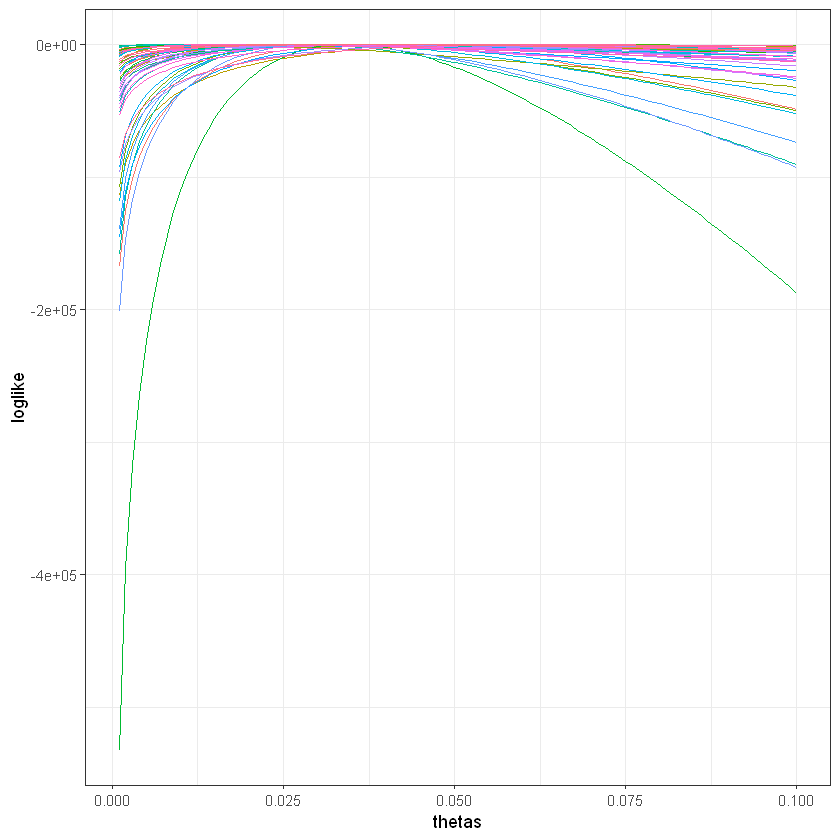

In [10]:
ggplot(lik_data, aes(x = thetas, y = loglike, colour = county)) +
    geom_line() + 
    theme_bw() +
    theme(legend.position = 'none')

# Confidence Intervals

Now let's actually plot the confidence intervals for the search, arrest, and hit rate for each county.

In [11]:
conf1$County <- factor(conf1$County, levels = conf1$County[order(conf1$Means)])
#standard deviation of the county estimates
sd(conf1$Means)

[1] 0.01227088

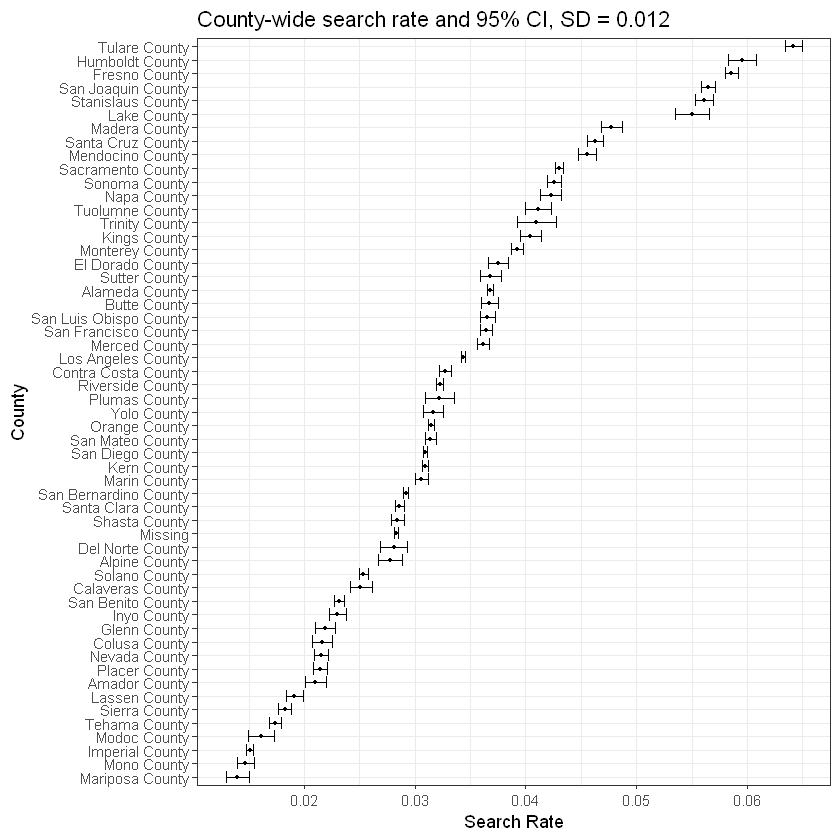

In [12]:
ggplot(conf1, aes(x = Means)) +
    geom_point(aes(x = Means, y = County, #colour = County
                  ), size = 0.7) +
    geom_errorbarh(aes(xmin = Lower, xmax = Upper, y = County, #colour = County
                      )) +
    theme_bw() +
    theme(legend.position = 'none') +
    xlab("Search Rate") +
    ggtitle("County-wide search rate and 95% CI, SD = 0.012")

The dots indicate the mean search rate, and the bars indicate the width of the 95% (profile) confidence interval. Bars that are shorter can be interpreted as having a higher degree of certainty, because we have larger sample sizes in those counties. Longer bars are less certain because we have less information. However, all the bars are extremely small because of the size of our data set. This is an aggregated version of 33 million traffic stops, and Los Angeles county alone consists of over 5 million traffic stops. With this much data, the confidence intervals are almost point estimates. This is OK for the time being.

Tulare, Humboldt, and Fresno counties have the highest search rates, while Imperial, Mono, and Mariposa counties have the lowest search rates. Los Angeles is middle of the pack, with teeny-tiny error bars, because we have millions of data points just from that county. San Francisco has a slightly higher search rate estimate than LA, but not by much. Our data with a missing county is fairly close to the center, with little uncertainty in its estimate.

The main take away here is that there seems to be a large amount of disrepancy between counties. The counties with the highest search rates look about 3 times higher than the counties with the lower search rates. Also, LA is the biggest county in California by far, and it has a very moderate search rate.

*Note* if two confidence intervals overlap in their values, that does *not* indicate that there is no statistically significant difference between counties. You can say there is a statistically significant difference if the error bars are *disjoint*, but the converse is not true if they overlap. When there is overlap, we actually can't make any claims.

Let's look at arrest rates now.

In [13]:
counties <- c()
means <- c()
lowerbounds <- c()
upperbounds <- c()

for (county in unique(aggdata$county_name)) {
    
    stops <- aggdata[aggdata$county_name == county,]$stops
    arrests <- aggdata[aggdata$county_name == county,]$arrests
    
    p_hat <- binom.profile(arrests, stops, conf.level = 0.95)[, 4]
    lower <- binom.profile(arrests, stops, conf.level = 0.95)[, 5]
    upper <- binom.profile(arrests, stops, conf.level = 0.95)[, 6]
    
    counties <- c(counties, county)
    means <- c(means, p_hat)
    lowerbounds <- c(lowerbounds, lower)
    upperbounds <- c(upperbounds, upper)
}

conf2 <- data.frame("County" = counties,
                             "Means" = means,
                             "Lower" = lowerbounds,
                             "Upper" = upperbounds)

conf2$County <- factor(conf2$County, levels = conf1$County[order(conf1$Means)])
#standard deviation of county estimates
sd(conf2$Means)

[1] 0.009154173

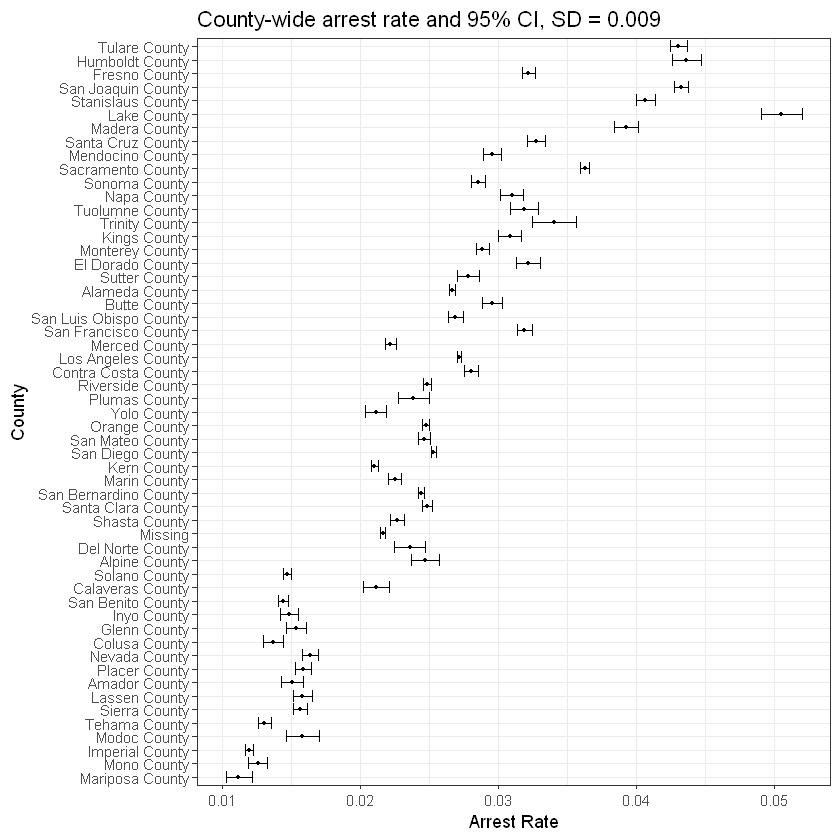

In [14]:
ggplot(conf2, aes(x = Means)) +
    geom_point(aes(x = Means, y = County, #colour = County
                  ), size = 0.7) +
    geom_errorbarh(aes(xmin = Lower, xmax = Upper, y = County, #colour = County
                      )) +
    theme_bw() +
    theme(legend.position = 'none') + 
    xlab("Arrest Rate") +
    ggtitle("County-wide arrest rate and 95% CI, SD = 0.009")

In this plot, I have kept the counties ordered by their search rates, so that we can see how arrest rates are not neccesarily perfectly predicted by the search rate. I found this plot a little surprising, since now counties with lower search rates sometimes have higher arrest rates. But there is definitely a large degree of correlation here, because  the overal structure to the graph seems to be intact. Counties with higher search rates seem to have higher arrest rates, but the structure is not perfect. In fact, there is a curious aspect of the data that explains some of this correlation.

Curious note: Fresno has the third highest search rate, but its arrest rate dropped significantly. Mariposa hasn't lost its place with the lowest search *and* arrest rate.

We'll see why in a bit. Let's move on to contraband hit rates.

In [15]:
counties <- c()
means <- c()
lowerbounds <- c()
upperbounds <- c()

for (county in unique(aggdata$county_name)) {
    
    searches <- aggdata[aggdata$county_name == county,]$searches
    hits <- aggdata[aggdata$county_name == county,]$hits
    
    p_hat <- binom.profile(hits, searches, conf.level = 0.95)[, 4]
    lower <- binom.profile(hits, searches, conf.level = 0.95)[, 5]
    upper <- binom.profile(hits, searches, conf.level = 0.95)[, 6]
    
    counties <- c(counties, county)
    means <- c(means, p_hat)
    lowerbounds <- c(lowerbounds, lower)
    upperbounds <- c(upperbounds, upper)
}

conf3 <- data.frame("County" = counties,
                             "Means" = means,
                             "Lower" = lowerbounds,
                             "Upper" = upperbounds)

conf3$County <- factor(conf3$County, levels = conf1$County[order(conf1$Means)])

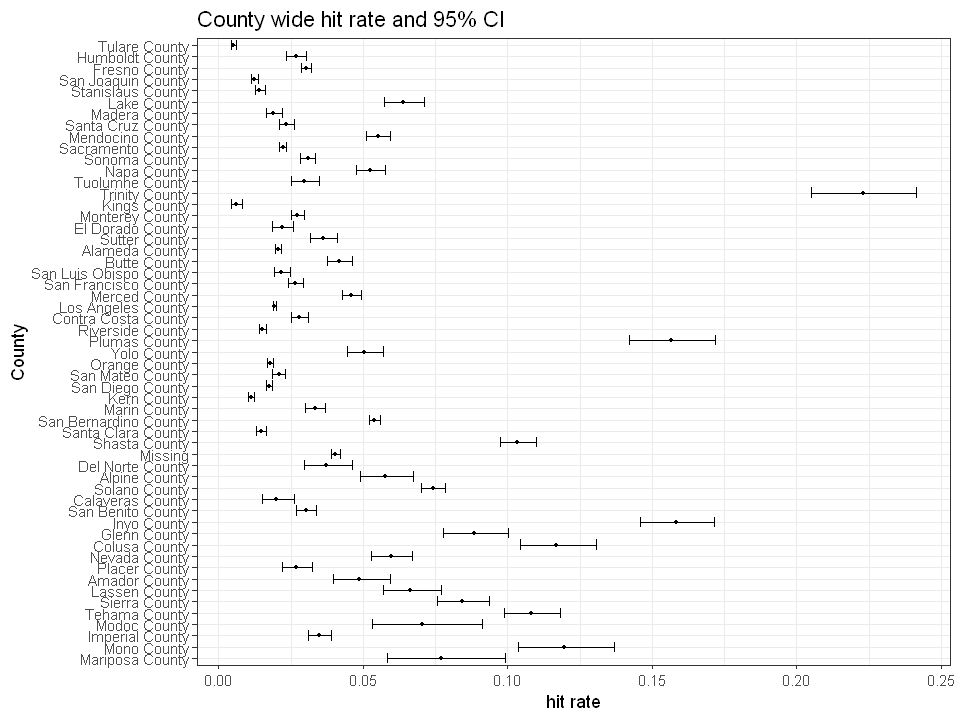

In [16]:
options(repr.plot.width=8, repr.plot.height=6)

ggplot(conf3, aes(x = Means)) +
    geom_point(aes(x = Means, y = County, #colour = County
                  ), size = 0.7) +
    geom_errorbarh(aes(xmin = Lower, xmax = Upper, y = County, #colour = County
                      )) +
    theme_bw() +
    theme(legend.position = 'none') +
    xlab("hit rate") +
    ggtitle("County wide hit rate and 95% CI")

Again, I have kept the counties ordered by the search rates. We would expect that counties with high search rates would have very high contraband hit rates,but this doesn't seem to be the case. Almost all of the structure from the above two plots is lost here. 

However, there is something to note: a lot of our contraband data is missing. In fact, we only have contraband data when the search was a result of probable cause or consent, in all other cases, the contraband data is omitted. So these estimates may not be valid, since we don't have information on most of the data. What happens if we only look at searches where contraband data is known?

In [17]:
head(aggdata)

county_name,stops,suspect_dui,move_violation,searches,non_arrest_srch,consent,probable,hits,arrests,warnings,chp215,collisions,chp281,search_rate,hit_rate,arrest_rate,ticket_rate,warning_rate
Alameda County,1718444,67388,579399,63198,28124,93,1996,1305,45826,282021,801185,112556,46755,0.03677629,0.02064939,0.02666715,0.4662270,0.1641142
Alpine County,91785,3719,48563,2545,654,18,195,147,2267,33014,32356,2069,2389,0.02772784,0.05776031,0.02469902,0.3525195,0.3596884
Amador County,87788,1229,38109,1844,1029,2,117,90,1321,16432,30135,2846,5476,0.02100515,0.04880694,0.01504761,0.3432702,0.1871782
Butte County,228030,9224,102837,8377,3259,16,451,349,6740,54817,107794,10041,7026,0.03673639,0.04166169,0.02955751,0.4727185,0.2403938
Calaveras County,95447,1771,37810,2395,996,7,67,48,2019,27488,20674,4214,6503,0.02509246,0.02004175,0.02115310,0.2166019,0.2879923
Colusa County,105650,1903,64207,2283,1397,15,344,267,1447,19737,54978,2246,601,0.02160909,0.11695138,0.01369617,0.5203786,0.1868150


In [18]:
#add the number of consensual and probable cause searches together
#this number is the number of searches for which we have known contraband outcomes
aggdata$open_srch <- aggdata$probable + aggdata$consent

counties <- c()
means <- c()
lowerbounds <- c()
upperbounds <- c()

for (county in unique(aggdata$county_name)) {
    
    searches <- aggdata[aggdata$county_name == county,]$open_srch
    hits <- aggdata[aggdata$county_name == county,]$hits
    
    p_hat <- binom.profile(hits, searches, conf.level = 0.95)[, 4]
    lower <- binom.profile(hits, searches, conf.level = 0.95)[, 5]
    upper <- binom.profile(hits, searches, conf.level = 0.95)[, 6]
    
    counties <- c(counties, county)
    means <- c(means, p_hat)
    lowerbounds <- c(lowerbounds, lower)
    upperbounds <- c(upperbounds, upper)
}

conf3 <- data.frame("County" = counties,
                             "Means" = means,
                             "Lower" = lowerbounds,
                             "Upper" = upperbounds)

conf3$County <- factor(conf3$County, levels = conf3$County[order(conf3$Means)])
#standard deviation of estimated means
sd(conf3$Means)

[1] 0.1099888

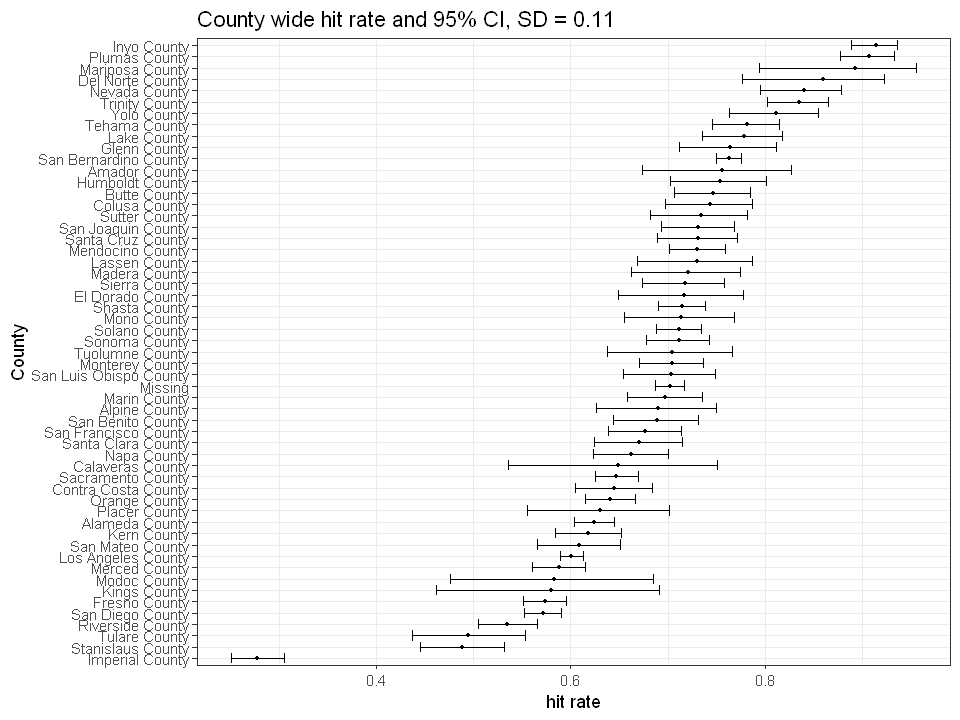

In [19]:
ggplot(conf3, aes(x = Means)) +
    geom_point(aes(x = Means, y = County, #colour = County
                  ), size = 0.7) +
    geom_errorbarh(aes(xmin = Lower, xmax = Upper, y = County, #colour = County
                      )) +
    theme_bw() +
    theme(legend.position = 'none') +
    xlab("hit rate") +
    ggtitle("County wide hit rate and 95% CI, SD = 0.11")

Note that I've reordered the intervals according to the hit rate (leaving them in the original orders was too messy). So, the first thing to see is that if we only look at probable cause and consensual searches, where the contraband data is actually known, the hit rate is WAY higher. We now have estimates that range between 35% and 85%. The other thing to note is that our error bars are HUGE in some counties. We really don't have a lot of information here, even with the aggregated version of the data, and we can't reliably estimate the hit rate. 

However, a couple things stand out. *Tulare County*, which had the *highest* search rate, has the third *lowest* hit rate for contraband. Los Angeles also tanked, and is in the bottom 1/4th, while having pretty close to the median search rate. Humbolt county still has a high contraband hit rate, but is still ranked 13th. 

Mariposa county, which had the *lowest* search rate, has one of the *highest* hit rates, but the estimate is pretty uncertain, with huge error bars. But Inyo county has fairly tight error bars and is ranked 1 on the hit rate, yet was in the bottom 1/4th of the data in terms of search rate.

### What is going on?

The take away here is that search rates don't seem to be predictive of the contraband hit rate, at least when the officer is working under probable cause or given consent to search. With aggregate data, it's tough to explore this further, but it should probably be noted when we model the data more completely later.

So, what's the deal? It's hard to say just yet. But it is certaintly very curious that counties with relatively low search rates (Mariposa, Nevada, Iona) have relatively high contraband hit rates. 

To get a better idea, why don't we plot some of these data points with a linear smoother (basically a fancy regression line) to get an idea of the overall trends?

In [20]:
aggdata$county <- gsub("\\s*\\w*$", "", aggdata$county_name)

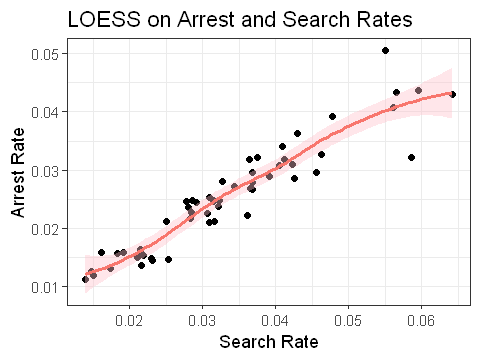

In [21]:
options(repr.plot.width=4, repr.plot.height=3)
ggplot(aggdata, aes(x = search_rate, y = arrest_rate)) +
    geom_point() +
    geom_smooth(method = 'loess', col= '#F8766D', se = T, fill = 'pink', alpha = 0.40) +
    #stat_smooth(method = 'lm') +
    #geom_text(aes(label = county), size = 2, check_overlap = T, hjust = 0, nudge_x = 0.001) +
    theme_bw() +
    xlab("Search Rate") +
    ylab("Arrest Rate") +
    ggtitle("LOESS on Arrest and Search Rates")

So, it looks like we have a pretty good linear correlation between the search rate and arrest rate. Why might that be? Well, while it wasnt shown here (it will be shown in a different note book), some of the searches are actually a *function of the arrests*. In the individual level data, we have a "search type" field, and one of those variables is "Incident to Arrest". I.e., the cop decided to arrest someone, THEN searched their car. In some sense, we are double counting the data, since we have some searches as a product of arrests, rather than the other way around. We will explore this more later. But the above line is likely not a good indicator of the true relationship.

One thing to note: as the search rate increases, the data points have a larger spread on the y-axis, indicating that there is more variance in the response. I.e., higher search rates increases the variability of the arrest rate. It's hard to know what that means for now, but it's something to note. Perhaps high search rates imply a lower standard of evidence?

I managed to store the number of searches that were not a product of arrests, it can be seen in the `head` below. This means that the difference between `searches - non_arrest_srch` is equal to the number of arrests that happened first, THEN yielded a search. In some cases, this number is very high. Let's look at the linear smoother between the number of searches that were NOT products of arrest, and the arrests that are a *result* of the searches.

In [22]:
head(aggdata)

county_name,stops,suspect_dui,move_violation,searches,non_arrest_srch,consent,probable,hits,arrests,...,chp215,collisions,chp281,search_rate,hit_rate,arrest_rate,ticket_rate,warning_rate,open_srch,county
Alameda County,1718444,67388,579399,63198,28124,93,1996,1305,45826,...,801185,112556,46755,0.03677629,0.02064939,0.02666715,0.4662270,0.1641142,2089,Alameda
Alpine County,91785,3719,48563,2545,654,18,195,147,2267,...,32356,2069,2389,0.02772784,0.05776031,0.02469902,0.3525195,0.3596884,213,Alpine
Amador County,87788,1229,38109,1844,1029,2,117,90,1321,...,30135,2846,5476,0.02100515,0.04880694,0.01504761,0.3432702,0.1871782,119,Amador
Butte County,228030,9224,102837,8377,3259,16,451,349,6740,...,107794,10041,7026,0.03673639,0.04166169,0.02955751,0.4727185,0.2403938,467,Butte
Calaveras County,95447,1771,37810,2395,996,7,67,48,2019,...,20674,4214,6503,0.02509246,0.02004175,0.02115310,0.2166019,0.2879923,74,Calaveras
Colusa County,105650,1903,64207,2283,1397,15,344,267,1447,...,54978,2246,601,0.02160909,0.11695138,0.01369617,0.5203786,0.1868150,359,Colusa


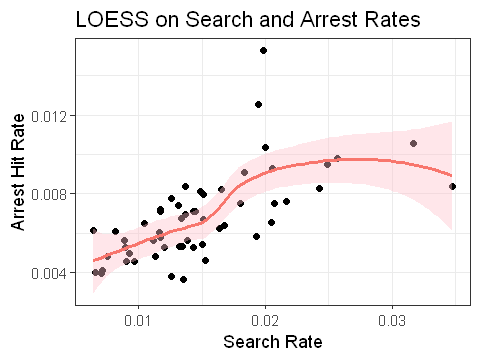

In [23]:
#compute arrests that are a result of searches
aggdata$arrest_then_search <- aggdata$searches - aggdata$non_arrest_srch
aggdata$search_then_arrest <- aggdata$arrests - aggdata$arrest_then_search

#compute the rates
aggdata$srch_then_arrest_rate <- aggdata$search_then_arrest / aggdata$stops
aggdata$nonarrest_srch_rate <- aggdata$non_arrest_srch / aggdata$stops

#plot
ggplot(aggdata, aes(x = nonarrest_srch_rate, y = srch_then_arrest_rate)) +
    geom_point() +
    geom_smooth(method = 'loess', col= '#F8766D', fill = 'pink', alpha = 0.40) +
    #stat_smooth(method = 'lm') +
    #geom_text(aes(label = county), size = 2, check_overlap = T, hjust = 0, nudge_x = 0.001) +
    theme_bw() +
    xlab("Search Rate") +
    ylab("Arrest Hit Rate") +
    ggtitle("LOESS on Search and Arrest Rates")

Now the data is a lot more murky. We do see some positive trend initially, but then once we cross the search rate of $0.02$, the variance explodes and the smoother arcs downwards. It's tough to know exactly what this means, but it seems to imply that if we think of a search as *leading* to an arrest, then higher search rates may not predict higher arrest rates. In fact, the arrest rates end up pretty low in this light.

We can explore this more fully later. Let's look at the contraband hit rates. As we noted before, we shouldn't use the total number of searches and the contraband hits, since we are missing a lot of the contraband data in that case. So, we should use only the searches that were a result of probable cause or consent, as those contraband fields are known.

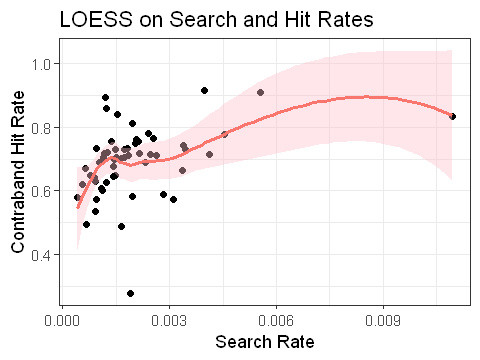

In [24]:
#compute the consent + PC search rate
aggdata$open_srch_rate <- aggdata$open_srch / aggdata$stops
aggdata$open_hit_rate <- aggdata$hits / aggdata$open_srch
#plot
ggplot(aggdata, aes(x = open_srch_rate, y = open_hit_rate)) +
    geom_point() +
    geom_smooth(method = 'loess', col= '#F8766D', fill = 'pink', alpha = 0.40) +
    #stat_smooth(method = 'lm') +
    #geom_text(aes(label = county), size = 2, check_overlap = T, hjust = 0, nudge_x = 0.001) +
    theme_bw() +
    xlab("Search Rate") +
    ylab("Contraband Hit Rate") +
    ggtitle("LOESS on Search and Hit Rates")

It's tough to know what to make of this plot. It actually looks like a random plotting of points. Let's try a linear regression.

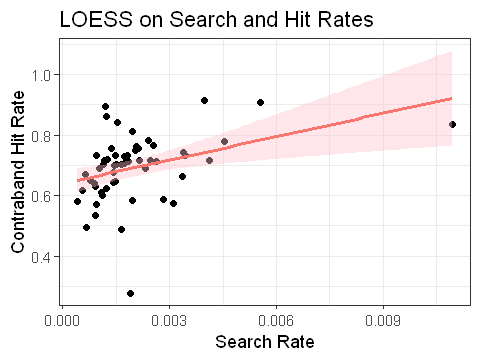

In [25]:
ggplot(aggdata, aes(x = open_srch_rate, y = open_hit_rate)) +
    geom_point() +
    geom_smooth(method = 'lm', col= '#F8766D', fill = 'pink', alpha = 0.40) +
    #stat_smooth(method = 'lm') +
    #geom_text(aes(label = county), size = 2, check_overlap = T, hjust = 0, nudge_x = 0.001) +
    theme_bw() +
    xlab("Search Rate") +
    ylab("Contraband Hit Rate") +
    ggtitle("LOESS on Search and Hit Rates")

Still no good. It's not clear at all that there is a linear relationship between the search rate and the contraband hit rate. It would be possible to generate a plot like this simply by plotting random points from a heavy tailed distribution, such as a student-t distribution. It *almost* looks like there is some structure, but it's hard to tell. 

For example, suppose there is actually no relationship at all between $x$ and $y$, then $y$ is not a function of $x$, and we could NOT write $y = b*x + \epsilon$, where $\epsilon$ is some random error. There would actually be no relationship. What happens if we take our search rate, and we just randomly generate a "contraband rate" using a some probability distribution? The contraband rates *are* clustered, so maybe something like a normal distribution with sufficiently small mean and standard deviation?



In [26]:
#mean hit rate
mean(aggdata$open_hit_rate)

[1] 0.69227

In [27]:
#standard deviation of the hit rate
sd(aggdata$open_hit_rate)

[1] 0.1099888

Lets try these values for a mean and standard deviation from a normal distribution.

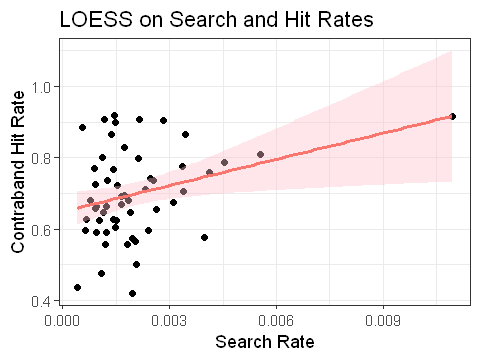

In [28]:
#generate random hit rates from a normal distribution
set.seed(2)
aggdata$sim_contraband <- rnorm(n = 55, mean = 0.69, sd = 0.11)

ggplot(aggdata, aes(x = open_srch_rate, y = sim_contraband)) +
    geom_point() +
    geom_smooth(method = 'lm', col= '#F8766D', fill = 'pink', alpha = 0.40) +
    #stat_smooth(method = 'lm') +
    #geom_text(aes(label = county), size = 2, check_overlap = T, hjust = 0, nudge_x = 0.001) +
    theme_bw() +
    xlab("Search Rate") +
    ylab("Contraband Hit Rate") +
    ggtitle("LOESS on Search and Hit Rates")

Look familiar? The only real difference is that the hit rates should be tighter together.

What about the estimated parameters from a linear regression line?

In [29]:
summary(lm(open_hit_rate ~ open_srch_rate, data = aggdata))


Call:
lm(formula = open_hit_rate ~ open_srch_rate, data = aggdata)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41122 -0.04125  0.01636  0.05069  0.22198 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.63990    0.02241  28.551  < 2e-16 ***
open_srch_rate 25.74200    8.65766   2.973  0.00443 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1028 on 53 degrees of freedom
Multiple R-squared:  0.143,	Adjusted R-squared:  0.1268 
F-statistic: 8.841 on 1 and 53 DF,  p-value: 0.004425


In [30]:
summary(lm(sim_contraband ~ open_srch_rate, data = aggdata))


Call:
lm(formula = sim_contraband ~ open_srch_rate, data = aggdata)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.276219 -0.064308 -0.009425  0.055787  0.235313 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.64884    0.02624  24.723   <2e-16 ***
open_srch_rate 24.50755   10.13787   2.417   0.0191 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1204 on 53 degrees of freedom
Multiple R-squared:  0.09931,	Adjusted R-squared:  0.08232 
F-statistic: 5.844 on 1 and 53 DF,  p-value: 0.0191


We get almost identical coefficients for the search rate (denoted `open_srch_rate`) in the two printout summarys, though with slightly different p-values (a result of the tighter clustering in the acutal data).

In reality, contraband hit rate might be related to the search rate in some way, but presently we aren't sure. The main thing to note is that generating *a completely random set of points* creates a scatter plot that looks remarkably similar to our current one. If we wanted to be fancy, we could probably use a mix of normal distributions and likely create a plot that was almost identical.

While I don't think that the contraband hit rate is spurious, after all, a sentient agent is deciding to conduct the search in order to find contraband. But the issue is that, if cops were perfect, or even very good at deciding who has contraband or doesnt, we should see a stronger relationship between the search rate and the hit rate. After all, a search would only be conducted in the face of sufficient evidence that contraband is present, but here we managed to recreate our plot with random point generation, so something is amiss.

Clearly, our current model is too simplistic to really get to the heart of the issue, but it does indicate that we should look deeper. We'll do this next when we actually begin modeling the data using more sophisticated techniques.

## Conclusion:

The counties appear to be fairly heterogeneous in their search, hit, and arrest rates. Tickets, warnings, and other metrics were not explored here but likely will be in a future notebook, or an updated of this notebook. Visual inspection of estimated search, arrest, and hit rates indicates that county level correlation between stop outcomes should not be ignored, but we'll assess this more formally in a different notebook. Counties with high search rates did not always have a high arrest rate, and often did not have a high contraband hit rate, when looking at searches conducted out of probable cause or consent. To really assess this relationship, a more complex model is needed.

There appears to be a relationship between search and arrest rates, but the relationship between search and contraband rates is less clear. In fact, randomly generated points can mimic the linear regression line and provide an almost identical estimated slope. 

All analysis was conducted on the aggregated data, ignoring possible systemtic differences in racial outcomes. The next round of analysis will begin to analyze these differences more formally.
